<a href="https://colab.research.google.com/github/JesseRed/Colab/blob/master/GAN_mnist_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.0
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
buffer_size = 1000
coding_size = 30
batch_size  = 32

def changing_tensor(item):
  item = tf.squeeze(item['image'])/255
  item.name = 'ck_mnist_tensorX'
  return item

dataset, info = tfds.load('mnist',split= 'train', with_info =True)
print(dataset.element_spec)
ds = dataset.map(lambda item: tf.squeeze(item['image']/255))
#ds = ds.map(lambda item: tf.py_function(func=changing_tensor,inp = [item], Tout=tf.float32)) 
print(ds.element_spec)
ds = ds.shuffle(buffer_size).batch(batch_size, drop_remainder = True).prefetch(1)
print(ds.element_spec)



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.
{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}
TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)
TensorSpec(shape=(32, 28, 28), dtype=tf.float32, name=None)


# Generator
Model of the Generator

In [0]:
coding_size = 30
inputs = tf.keras.Input(shape=(coding_size,))
x = tf.keras.layers.Dense(100,activation='selu')(inputs)
x = tf.keras.layers.Dense(150,activation='selu')(x)
x = tf.keras.layers.Dense(28*28,activation='sigmoid')(x)
outputs = tf.keras.layers.Reshape((28,28))(x)
generator = tf.keras.Model(inputs=inputs, outputs = outputs)

In [0]:
coding_size = 100
inputs = tf.keras.Input(shape=(coding_size,))
x = tf.keras.layers.Dense(7*7*128,activation='selu')(inputs)
x = tf.keras.layers.Reshape((7,7,128))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Conv2DTranspose(1,kernel_size=5, strides=2, padding='same', activation='tanh')(x)
generator = tf.keras.Model(inputs=inputs, outputs = outputs)

# Discriminator
Model of the Discriminator

In [0]:
inputs = tf.keras.Input(shape=(28,28))
x = tf.keras.layers.Flatten(input_shape = [28,28])(inputs)
x = tf.keras.layers.Dense(150,activation='selu')(x)
x = tf.keras.layers.Dense(100,activation='selu')(x)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
discriminator = tf.keras.Model(inputs = inputs, outputs=outputs)

In [0]:
inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(64,kernel_size=5, padding='same', activation=tf.keras.layers.LeakyReLU(0.2))(inputs)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=5, strides = 2, padding = 'same', activation= tf.keras.layers.LeakyReLU(0.2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
discriminator = tf.keras.Model(inputs=inputs, outputs = outputs)

In [7]:

dataset, info = tfds.load('mnist',split= 'train', with_info =True)
print(dataset.element_spec)
ds = dataset.map(lambda item: tf.reshape(tf.squeeze(item['image']/255*2-1), [28,28,1]))
print(ds.element_spec)
ds = ds.shuffle(buffer_size).batch(batch_size, drop_remainder = True).prefetch(1)
print(ds.element_spec)


{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}
TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)
TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float32, name=None)


#Compiling the Models


In [0]:
gan = tf.keras.Sequential([generator, discriminator])
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer= 'rmsprop')


#Training Function

In [0]:
def train_the_gan(gan, dataset, batch_size, coding_size, n_epochs = 20):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print(f"epoch = {epoch}")
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, coding_size])
      generated_images = generator(noise)
      X_batch_fake_and_real = tf.concat([generated_images, X_batch],axis = 0)
      y1 = tf.constant([[0.]]*batch_size +[[1.]]*batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_batch_fake_and_real, y1)
      # generator training
      
      noise = tf.random.normal(shape=[batch_size, coding_size])
      y2 = tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y2)



In [10]:
train_the_gan(gan, ds, batch_size, coding_size, 40)

epoch = 0
epoch = 1
epoch = 2
epoch = 3
epoch = 4
epoch = 5
epoch = 6
epoch = 7
epoch = 8
epoch = 9
epoch = 10
epoch = 11
epoch = 12
epoch = 13
epoch = 14
epoch = 15
epoch = 16
epoch = 17
epoch = 18
epoch = 19
epoch = 20
epoch = 21
epoch = 22
epoch = 23
epoch = 24
epoch = 25
epoch = 26
epoch = 27
epoch = 28
epoch = 29
epoch = 30
epoch = 31
epoch = 32
epoch = 33
epoch = 34
epoch = 35
epoch = 36
epoch = 37
epoch = 38
epoch = 39


In [37]:
dummy = [0.]*5 +[0.]*5
print(type(dummy))
dummy

<class 'list'>


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(28, 28)


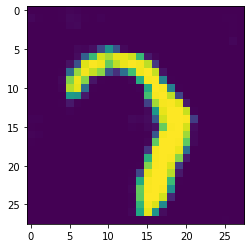

In [28]:
noise = tf.random.normal(shape=[1,coding_size])
print(noise.shape)
image = generator(noise)
print(type(image))
image = tf.squeeze(image)
print(image.shape)
plt.imshow(image)